# NHL predictions project - Data Interpretation

This is project for the subject Data Processing in Python - JEM207. That was created by Pavlína Křenková and Vojtěch Vaverka.

The code we wrote scrapes data from the website https://nhl.cz/. After the data is scraped, user of the code needs to fill in names of two teams into the variables team_1 and team_2. Once those two variables are set the code creates a Logistic regression that predicts which team is going to win. Druing our testing of the code we have reached accuracy above 50%. That means that the model is better than randomly guessing. Yet it should not be used to place bets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from statistics import mean
from ipywidgets import Dropdown

We load the necessary information about the teams, which we will later use for file loading and analysis

In [2]:
teams_info = pd.read_csv('teams_info/teams_info.csv')
#teams_info.head()

In [3]:
#We will be analysing the 5 most recent seasons
seasons_used = ['2017', '2018', '2019', '2020','2021'] #2017 is the 2017/2018 season, etc.

In [4]:
distinct_teams = teams_info['team'].tolist()

In [5]:
teams_dict = pd.Series(teams_info.team_short.values,index=teams_info.team).to_dict()
teams_dict

{'Anaheim Ducks': 'ANA',
 'Arizona Coyotes': 'ARI',
 'Boston Bruins': 'BOS',
 'Buffalo Sabres': 'BUF',
 'Calgary Flames': 'CGY',
 'Carolina Hurricanes': 'CAR',
 'Chicago Blackhawks': 'CHI',
 'Colorado Avalanche': 'COL',
 'Columbus Blue Jackets': 'CBJ',
 'Dallas Stars': 'DAL',
 'Detroit Red Wings': 'DET',
 'Edmonton Oilers': 'EDM',
 'Florida Panthers': 'FLA',
 'Los Angeles Kings': 'LAK',
 'Minnesota Wild': 'MIN',
 'Montreal Canadiens': 'MTL',
 'Nashville Predators': 'NSH',
 'New Jersey Devils': 'NJD',
 'New York Islanders': 'NYI',
 'New York Rangers': 'NYR',
 'Ottawa Senators': 'OTT',
 'Philadelphia Flyers': 'PHI',
 'Pittsburgh Penguins': 'PIT',
 'San Jose Sharks': 'SJS',
 'Seattle Kraken': 'SEA',
 'St. Louis Blues': 'STL',
 'Tampa Bay Lightning': 'TBL',
 'Toronto Maple Leafs': 'TOR',
 'Vancouver Canucks': 'VAN',
 'Vegas Golden Knights': 'VGK',
 'Washington Capitals': 'WSH',
 'Winnipeg Jets': 'WPG'}

## Choosing two teams and building the model

In [6]:
teams_info = pd.read_csv('teams_info/teams_info.csv')
option_list = teams_info['team'].tolist()
option_list.insert(0, '')
team_1_drop = ''
team_2_drop = ''
drop_down_team_1 = Dropdown(options=option_list,description='Choose the home team (Team 1):',disabled=False, 
                     display='flex',
                     flex_flow='column', align_items='stretch', style= {'description_width': 'initial'},
                     layout={'width': 'max-content'})
drop_down_team_2 = Dropdown(options=option_list,description='Choose the away team (Team 2):',disabled=False, 
                     display='flex',
                     flex_flow='column', align_items='stretch', style= {'description_width': 'initial'},
                     layout={'width': 'max-content'})
def dropdown_handler_team_1(choice):
    global team_1_drop
    print("Team 1:", choice.new)
    team_1_drop = choice.new
def dropdown_handler_team_2(choice):
    global team_2_drop
    print("Team 2:", choice.new)
    team_2_drop = choice.new
drop_down_team_1.observe(dropdown_handler_team_1, names='value')
drop_down_team_2.observe(dropdown_handler_team_2, names='value')
display(drop_down_team_1, drop_down_team_2)

Dropdown(description='Choose the home team (Team 1):', layout=Layout(width='max-content'), options=('', 'Anahe…

Dropdown(description='Choose the away team (Team 2):', layout=Layout(width='max-content'), options=('', 'Anahe…

Team 1: Carolina Hurricanes
Team 1: Arizona Coyotes
Team 2: Pittsburgh Penguins


In [59]:
if team_1_drop == "" or team_2_drop == "":  
    print("You have not chosen both teams yet, please return to previous cell and do so.")
    
    # A base arbitrary choice was made, so that all cells can be run at once.
    team_1 = "Boston Bruins"
    team_2 = "Tampa Bay Lightning"
    
    
elif team_1_drop == team_2_drop:
    
    print("You picked the same team twice, please return to previous cell and change at least one team.")
    # A base arbitrary choice was made, so that analysis can continue if user does not specify..
    # ..teams correctly
    team_1 = team_1_drop
    if team_1 == "Boston Bruins":
        team_2 = "Tampa Bay Lightning"
    else:
        team_2 = "Boston Bruins"
    
else:
    print("The outcome of the match", team_1_drop, "vs", team_2_drop, "will be predicted.")
    team_1 = team_1_drop
    team_2 = team_2_drop

The outcome of the match Arizona Coyotes vs Pittsburgh Penguins will be predicted.


In [60]:
team_1_short = teams_dict[team_1]
team_2_short = teams_dict[team_2]

In [61]:
matches_team_1 = pd.read_csv(f'teams_final/{team_1_short}.csv')
matches_team_1.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,/zapas/2526365,1.0,0.0,Arizona Coyotes,Toronto Maple Leafs,11.0,49.0,78.0,34.0,72.0,61.0
1,/zapas/2526399,1.0,1.0,Arizona Coyotes,Los Angeles Kings,14.0,50.0,73.0,29.0,59.0,51.0
2,/zapas/2526408,0.0,1.0,Arizona Coyotes,Vegas Golden Knights,16.0,51.0,69.0,36.0,75.0,63.0
3,/zapas/2526429,0.0,0.0,Arizona Coyotes,Edmonton Oilers,16.0,52.0,70.0,23.0,56.0,65.0
4,/zapas/2526440,0.0,0.0,Arizona Coyotes,Calgary Flames,17.0,50.0,68.0,27.0,58.0,67.0


In [62]:
#dropping unnecessary columns
matches_team_1 = matches_team_1.drop(columns=['game_id', 'TOI','other_team'])

#### Defining the independent and dependent variables

In [63]:
#independent
x = matches_team_1.iloc[:, 1:].values
#dependent - the result
y = matches_team_1.iloc[:, 0].values

#### Splitting into training and test set

In [64]:
matches_team_1.iloc[:, 1:]

,TOI_home,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,0.0,11.0,49.0,78.0,34.0,72.0,61.0
1,1.0,14.0,50.0,73.0,29.0,59.0,51.0
2,1.0,16.0,51.0,69.0,36.0,75.0,63.0
3,0.0,16.0,52.0,70.0,23.0,56.0,65.0
4,0.0,17.0,50.0,68.0,27.0,58.0,67.0
...,...,...,...,...,...,...,...
343,1.0,13.0,43.0,89.0,37.0,81.0,71.0
344,1.0,13.0,41.0,88.0,41.0,85.0,62.0
345,0.0,11.0,40.0,90.0,45.0,78.0,50.0
346,0.0,11.0,39.0,90.0,35.0,55.0,60.0


In [65]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [66]:
X_test[:5]

array([[ 0., 20., 50., 62., 31., 72., 69.],
       [ 0., 36., 57., 48., 34., 74., 68.],
       [ 1., 19., 54., 70., 36., 71., 55.],
       [ 1., 33., 49., 51., 35., 61., 52.],
       [ 0., 14., 38., 67., 36., 63., 48.]])

In [67]:
#rescaling everything except the "home" dummy ... and then adding the dummy back
scaler = StandardScaler()
X_train_stand = scaler.fit_transform(X_train[:,1:])
X_test_stand = scaler.transform(X_test[:,1:])
X_train_stand = np.insert(X_train_stand,0,X_train[:,0],axis=1)
X_test_stand = np.insert(X_test_stand,0,X_test[:,0],axis=1)

#### The model and predictions

In [68]:
reg = LogisticRegression(max_iter = 400)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [69]:
#how well does the model perform?
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[16  2]
 [15  2]]


In [70]:
print("Accuracy :  \n", accuracy_score(y_test, y_pred))

Accuracy :  
 0.5142857142857142


In [71]:
matches_team_2 = pd.read_csv(f'teams_final/{team_2_short}.csv')
matches_team_2.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot
0,/zapas/2526378,0.0,1.0,Pittsburgh Penguins,Vancouver Canucks,31.0,54.0,60.0,30.0,53.0,57.0
1,/zapas/2526388,0.0,0.0,Pittsburgh Penguins,Boston Bruins,28.0,52.0,65.0,30.0,54.0,59.0
2,/zapas/2526407,1.0,1.0,Pittsburgh Penguins,Tampa Bay Lightning,25.0,52.0,67.0,44.0,75.0,49.0
3,/zapas/2526417,1.0,1.0,Pittsburgh Penguins,Philadelphia Flyers,28.0,53.0,64.0,24.0,57.0,63.0
4,/zapas/2526442,1.0,0.0,Pittsburgh Penguins,Buffalo Sabres,27.0,54.0,65.0,20.0,44.0,63.0


### the final prediction

In [72]:
matches_team_1_pre = pd.read_csv(f'teams_pre-processed/{team_1_short}_pre.csv')
matches_team_2_pre = pd.read_csv(f'teams_pre-processed/{team_2_short}_pre.csv')

In [73]:
pred_team_1 = matches_team_1_pre[['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']].tail(20).sum().values

In [74]:
#je to v poradi points-goals scored-goals received
pred_team_1

array([16., 45., 89.])

In [75]:
pred_team_2 = matches_team_2_pre[['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']].tail(20).sum().values
pred_team_2

array([27., 71., 63.])

In [76]:
TOI_home = np.array([1])

In [77]:
values_to_fit = np.concatenate([TOI_home, pred_team_1, pred_team_2]).reshape(1, -1)

In [78]:
final_pred = reg.predict(values_to_fit)
final_pred

array([0.])

In [79]:
if final_pred[0] == 1:
    print('The team', team_1, "is predicted to win this game.")
elif final_pred[0] == 0:
    print('The team', team_2, "is predicted to win this game.")
else:
    print('An error occured along the way. Please try again.')

The team Pittsburgh Penguins is predicted to win this game.


## Accuraccy of models of individual teams

In [80]:
#How accurate is the model for individual teams?
accuracies = []
for one_team in distinct_teams:
    one_team_short = teams_dict[one_team]
    matches_one_team = pd.read_csv(f'teams_final/{one_team_short}.csv')
    matches_one_team = matches_one_team.drop(columns=['game_id', 'TOI','other_team'])
    x = matches_one_team.iloc[:, 1:].values
    y = matches_one_team.iloc[:, 0].values
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

    scaler = StandardScaler()
    X_train_stand = scaler.fit_transform(X_train[:,1:])
    X_test_stand = scaler.transform(X_test[:,1:])
    X_train_stand = np.insert(X_train_stand,0,X_train[:,0],axis=1)
    X_test_stand = np.insert(X_test_stand,0,X_test[:,0],axis=1)
    reg = LogisticRegression(max_iter = 400)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))
    

print((accuracies))
print(sum(acc < 0.5 for acc in accuracies)) #4 teams out of 32 have lower then 0.5 accuracy

[0.5277777777777778, 0.5142857142857142, 0.6944444444444444, 0.6285714285714286, 0.5555555555555556, 0.6, 0.5277777777777778, 0.5555555555555556, 0.4722222222222222, 0.5714285714285714, 0.6388888888888888, 0.6388888888888888, 0.5833333333333334, 0.5555555555555556, 0.6, 0.5277777777777778, 0.5428571428571428, 0.6285714285714286, 0.5142857142857142, 0.45714285714285713, 0.75, 0.5428571428571428, 0.42857142857142855, 0.5, 0.7142857142857143, 0.5277777777777778, 0.6944444444444444, 0.4166666666666667, 0.5142857142857142, 0.6666666666666666, 0.6, 0.5833333333333334]
4


In [81]:
mean(accuracies) #the model is 57% accurate, on average

0.5710565476190476

### Calculating Home Advantage

In [82]:
#ja moc nevim jestli tenhle vypocet je dobre
all_matches = pd.read_csv('all_matches.csv')
sum_wins_home = sum(all_matches["goals_home"] > all_matches["goals_away"])
sum_wins_away = sum(all_matches["goals_home"] < all_matches["goals_away"])
 
home_winrate = sum_wins_home/(sum_wins_home+sum_wins_away)
home_winrate

0.5413507925568574

### calculating and visualising home advantage for all teams for all seasons together

In [83]:
home_advantages = {}
for one_team in distinct_teams:
    one_team_short = teams_dict[one_team]
    matches_one_team = pd.read_csv(f'teams_final/{one_team_short}.csv')
    home_ad = (sum((matches_one_team['TOI_home'] == 1) & (matches_one_team['TOI_result'] == 1)))/sum(matches_one_team['TOI_home'] == 1)
    home_advantages[one_team] = home_ad
    
home_advantages

#add points total, so that we can see if it corresponds

{'Anaheim Ducks': 0.4508670520231214,
 'Arizona Coyotes': 0.42528735632183906,
 'Boston Bruins': 0.6704545454545454,
 'Buffalo Sabres': 0.42134831460674155,
 'Calgary Flames': 0.5375722543352601,
 'Carolina Hurricanes': 0.6149425287356322,
 'Chicago Blackhawks': 0.42857142857142855,
 'Colorado Avalanche': 0.6514285714285715,
 'Columbus Blue Jackets': 0.5284090909090909,
 'Dallas Stars': 0.5795454545454546,
 'Detroit Red Wings': 0.39664804469273746,
 'Edmonton Oilers': 0.5375722543352601,
 'Florida Panthers': 0.6440677966101694,
 'Los Angeles Kings': 0.4797687861271676,
 'Minnesota Wild': 0.6193181818181818,
 'Montreal Canadiens': 0.43258426966292135,
 'Nashville Predators': 0.6022727272727273,
 'New Jersey Devils': 0.41954022988505746,
 'New York Islanders': 0.550561797752809,
 'New York Rangers': 0.5202312138728323,
 'Ottawa Senators': 0.44,
 'Philadelphia Flyers': 0.49714285714285716,
 'Pittsburgh Penguins': 0.6460674157303371,
 'San Jose Sharks': 0.5172413793103449,
 'Seattle Kraken

### calculating and visualising home advantage for individual seasons

In [84]:
home_advantage = pd.DataFrame(seasons_used, columns=['year'])
ha = []
for season in seasons_used:
    ha_one_season = sum(all_matches.loc[all_matches['season'] == int(season)]["home_wins"])/len(all_matches.loc[all_matches['season'] == int(season)]["home_wins"])
    ha.append(round(ha_one_season*100,3))
home_advantage["win_home_percentage"] = ha
home_advantage

,year,win_home_percentage
0,2017,56.334
1,2018,53.659
2,2019,53.327
3,2020,53.341
4,2021,53.659


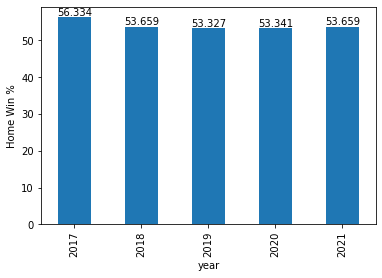

In [85]:
ha = home_advantage.plot(x = 'year', legend=False, kind = "bar")
plt.ylabel("Home Win %")
ha.bar_label(ha.containers[0], labels=home_advantage['win_home_percentage'])
plt.show()

### calculating home advantage for all teams and all seasons

In [86]:
sum(all_matches["home_wins"])/len(all_matches["home_wins"])

0.5413507925568574

### calculating and visualising home advantage for one specific team and all seasons

### After picking 2 teams both their final_dfs are found, saved and displayed

In [87]:
matches_team_1s = pd.read_csv(f'teams_final/{team_1_short}.csv')
matches_between_them = matches_team_1s.merge(matches_team_2, left_on='game_id', right_on='game_id',suffixes=('', '2'))
matches_between_them.drop(columns=['TOI_result2', 'TOI_home2','TOI2','other_team2','TOI_points_tot2','TOI_goals_scored_tot2','TOI_goals_rec_tot2'], inplace=True)
pd.set_option("display.max_rows", None, "display.max_columns", None)
matches_between_them.head()

,game_id,TOI_result,TOI_home,TOI,other_team,TOI_points_tot,TOI_goals_scored_tot,TOI_goals_rec_tot,other_team_points_tot,other_team_goals_scored_tot,other_team_goals_rec_tot,other_team_points_tot2,other_team_goals_scored_tot2,other_team_goals_rec_tot2
0,/zapas/2526557,0.0,1.0,Arizona Coyotes,Pittsburgh Penguins,19.0,39.0,57.0,26.0,59.0,56.0,19.0,39.0,57.0
1,/zapas/2647447,0.0,0.0,Arizona Coyotes,Pittsburgh Penguins,30.0,59.0,48.0,29.0,68.0,64.0,30.0,59.0,48.0
2,/zapas/2647936,0.0,1.0,Arizona Coyotes,Pittsburgh Penguins,21.0,54.0,66.0,41.0,74.0,50.0,21.0,54.0,66.0
3,/zapas/2806825,0.0,0.0,Arizona Coyotes,Pittsburgh Penguins,31.0,54.0,48.0,28.0,64.0,58.0,31.0,54.0,48.0
4,/zapas/2807082,0.0,1.0,Arizona Coyotes,Pittsburgh Penguins,29.0,57.0,58.0,39.0,69.0,57.0,29.0,57.0,58.0


In [88]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)

In [89]:
matches_between_them_ids = matches_between_them['game_id']
matches_between_them_ids

0    /zapas/2526557
1    /zapas/2647447
2    /zapas/2647936
3    /zapas/2806825
4    /zapas/2807082
5    /zapas/2897731
6    /zapas/2897965
Name: game_id, dtype: object

### Graphs

#### We create data frames for graphs and we ad variable match_ordr that displays the order of matches of a given team

In [90]:
matches_team_1_graphs = pd.read_csv(f'teams_pre-processed/{team_1_short}_pre.csv')
matches_team_2_graphs = pd.read_csv(f'teams_pre-processed/{team_2_short}_pre.csv')
matches_team_1_graphs['match_ordr'] = range(1, len(matches_team_1_graphs) + 1)
matches_team_2_graphs['match_ordr'] = range(1, len(matches_team_2_graphs) + 1)
matches_team_2_graphs.head()

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr
0,/zapas/2526056,Pittsburgh Penguins,St. Louis Blues,4,5,1,1.0,...,4.0,5.0,0.0,St. Louis Blues,Pittsburgh Penguins,2017,1
1,/zapas/2526064,Chicago Blackhawks,Pittsburgh Penguins,10,1,0,3.0,...,1.0,10.0,0.0,Chicago Blackhawks,Pittsburgh Penguins,2017,2
2,/zapas/2526075,Pittsburgh Penguins,Nashville Predators,4,0,0,3.0,...,4.0,0.0,1.0,Nashville Predators,Pittsburgh Penguins,2017,3
3,/zapas/2526101,Washington Capitals,Pittsburgh Penguins,2,3,0,0.0,...,3.0,2.0,1.0,Washington Capitals,Pittsburgh Penguins,2017,4
4,/zapas/2526105,Tampa Bay Lightning,Pittsburgh Penguins,5,4,0,3.0,...,4.0,5.0,0.0,Tampa Bay Lightning,Pittsburgh Penguins,2017,5


### Merge both teams into one dataframe and create a graph of scored goals

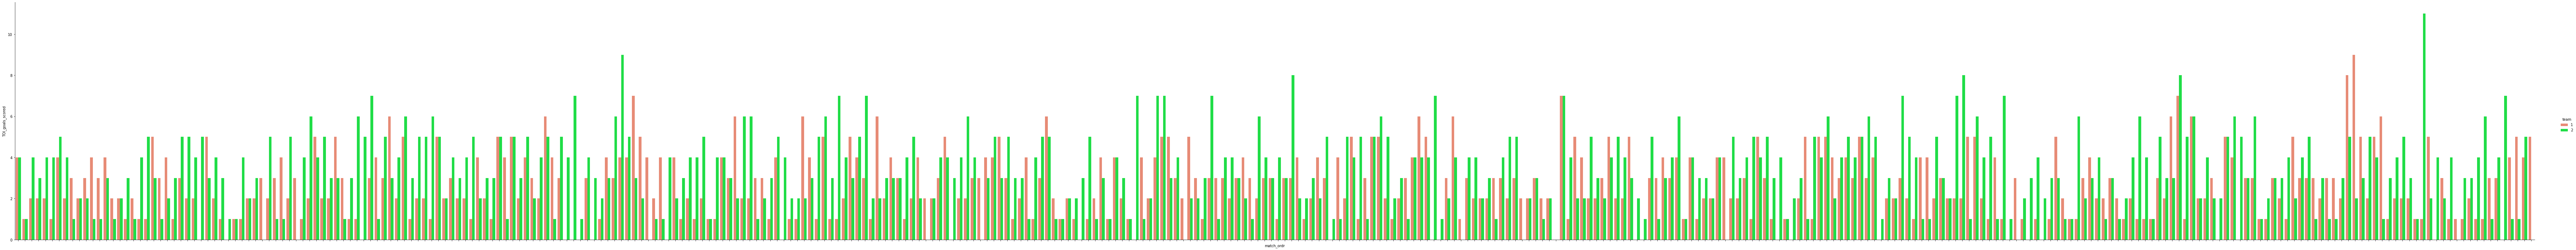

In [91]:
graphs = pd.concat([matches_team_1_graphs, matches_team_2_graphs], axis=0, ignore_index=False)
graphs['team'] = (len(matches_team_1_graphs)*(1,) + len(matches_team_2_graphs)*(2,))
graph_1 = sns.catplot(x='match_ordr', y='TOI_goals_scored', hue='team', kind='bar', data=graphs, height=10, aspect=10, palette=["#FA7F63", "#00FC35"])
graph_1.set(xticklabels=[])
plt.show()

#### Too many matches we need to limit the data to last 30 matches

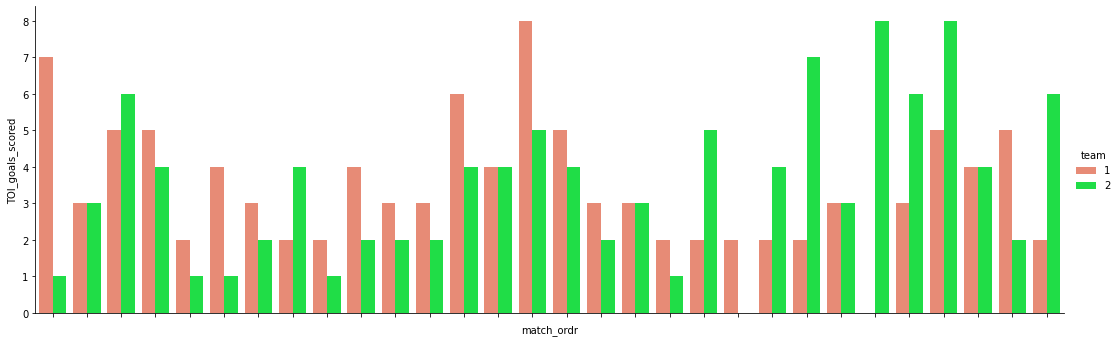

In [40]:
matches_team_1_graphs_30 = matches_team_1_graphs.tail(30)
matches_team_2_graphs_30 = matches_team_2_graphs.tail(30)
graphs_30_matches = pd.concat([matches_team_1_graphs_30, matches_team_2_graphs_30], axis=0, ignore_index=False)
graphs_30_matches['team'] = (len(matches_team_1_graphs_30)*(1,) + len(matches_team_2_graphs_30)*(2,))
graphs_30_matches
graph_2 = sns.catplot(x='match_ordr', y='TOI_goals_scored', hue='team', kind='bar', data=graphs_30_matches, height=5, aspect=3, palette=["#FA7F63", "#00FC35"])
graph_2.set(xticklabels=[])
plt.show()

### Recived Goals

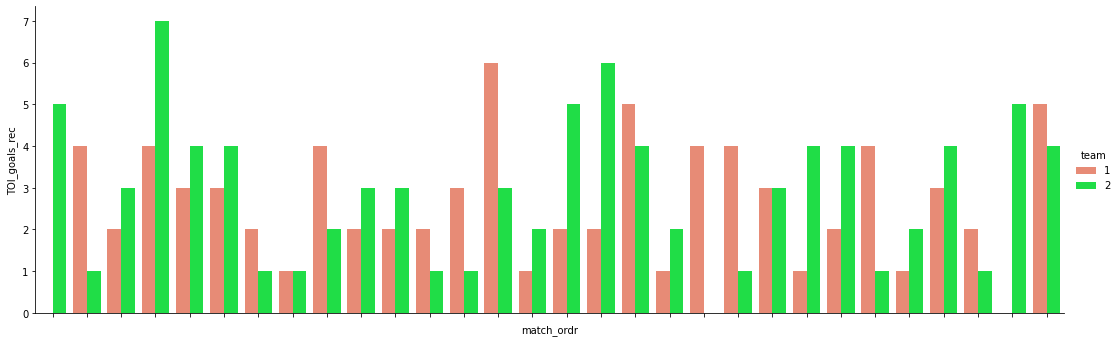

In [41]:
graph_3 = sns.catplot(x='match_ordr', y='TOI_goals_rec', hue='team', kind='bar', data=graphs_30_matches, height=5, aspect=3, palette=["#FA7F63", "#00FC35"])
graph_3.set(xticklabels=[])
plt.show()

### How teams did in last 30 matches

<function matplotlib.pyplot.show(close=None, block=None)>

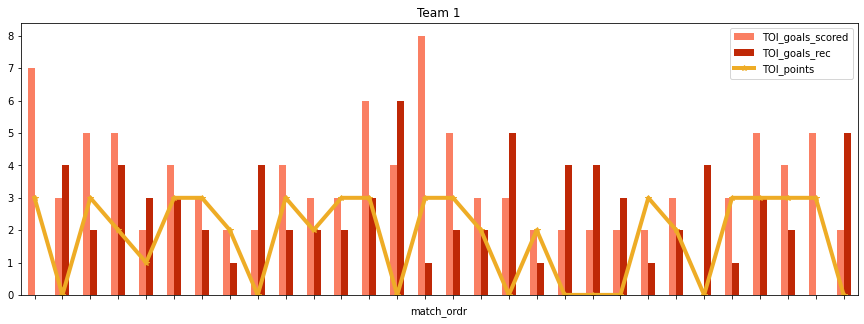

In [42]:
ax = matches_team_1_graphs_30[['TOI_goals_scored','TOI_goals_rec','match_ordr']].plot(
    x='match_ordr',kind='bar',figsize=(15, 5),color=["#FA7F63", "#BF2806"],title='Team 1')
matches_team_1_graphs_30[['TOI_points','match_ordr']].plot(x='match_ordr',  linestyle='-', marker='*',figsize=(15, 5),use_index=False,
                                                   color=["#EEAC26"], lw=4, ax=ax)
ax.set(xticklabels=[])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

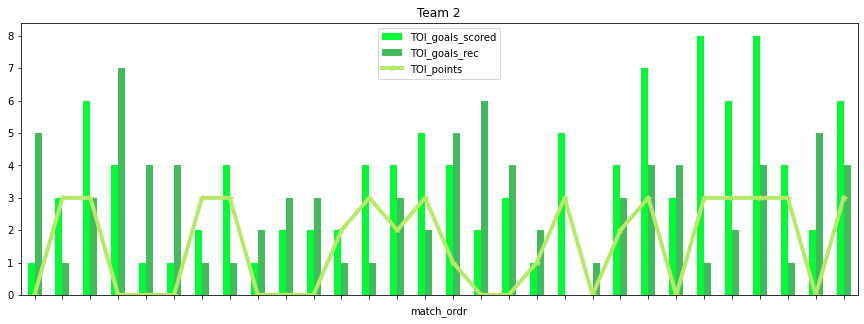

In [43]:
ax = matches_team_2_graphs_30[['TOI_goals_scored','TOI_goals_rec','match_ordr']].plot(
    x='match_ordr',kind='bar',figsize=(15, 5),color=["#00FC35", "#42BB5C"],title='Team 2')
matches_team_2_graphs_30[['TOI_points','match_ordr']].plot(x='match_ordr',  linestyle='-', marker='*',figsize=(15, 5),use_index=False,
                                                   color=["#B6E968"], lw=4, ax=ax)
ax.set(xticklabels=[])
plt.show

### Comparison of important variables for our model

<function matplotlib.pyplot.show(close=None, block=None)>

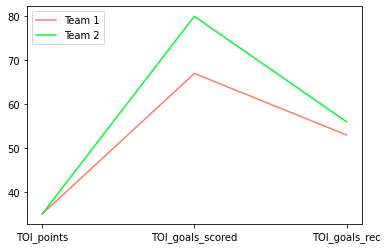

In [44]:
x_coordinates = ['TOI_points', 'TOI_goals_scored', 'TOI_goals_rec']
X_axis = np.arange(len(x_coordinates))
plt.plot(x_coordinates, pred_team_1,'#FA7F63',label="Team 1") 
plt.plot(x_coordinates, pred_team_2,'#00FC35',label="Team 2") 
plt.legend(loc="upper left")
plt.show

### 2nd model based on matches between 2 teams

In [45]:
#TOI = team 1 and should be home team to reflect home team advantage
second_model_mathes_filtered= matches_team_1_pre[matches_team_1_pre.other_team == team_2].copy()
second_model_mathes_filtered['match_ordr'] = range(1, len(second_model_mathes_filtered) + 1)
second_model_mathes_filtered

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,TOI_goals_scored,TOI_goals_rec,TOI_result,other_team,TOI,season,match_ordr
22,/zapas/2526431,Boston Bruins,Tampa Bay Lightning,3,2,0,3.0,...,3.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,1
69,/zapas/2527156,Tampa Bay Lightning,Boston Bruins,0,3,0,0.0,...,3.0,0.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,2
75,/zapas/2527244,Boston Bruins,Tampa Bay Lightning,4,2,0,3.0,...,4.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2017,3
78,/zapas/2527287,Tampa Bay Lightning,Boston Bruins,4,0,0,3.0,...,0.0,4.0,0.0,Tampa Bay Lightning,Boston Bruins,2017,4
109,/zapas/2647632,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,...,2.0,3.0,0.0,Tampa Bay Lightning,Boston Bruins,2018,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,/zapas/2807430,Boston Bruins,Tampa Bay Lightning,3,5,0,0.0,...,3.0,5.0,0.0,Tampa Bay Lightning,Boston Bruins,2019,12
310,/zapas/2897351,Boston Bruins,Tampa Bay Lightning,2,3,1,1.0,...,2.0,3.0,0.0,Tampa Bay Lightning,Boston Bruins,2021,13
320,/zapas/2897606,Tampa Bay Lightning,Boston Bruins,2,5,0,0.0,...,5.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2021,14
353,/zapas/2898005,Boston Bruins,Tampa Bay Lightning,3,2,0,3.0,...,3.0,2.0,1.0,Tampa Bay Lightning,Boston Bruins,2021,15


### 2nd model here we predict winner based on wins and loses in duels between teams

In [46]:
model_2_data = sum(second_model_mathes_filtered.TOI_result)/len(second_model_mathes_filtered.TOI_result)
if model_2_data >= 0.5:
  print(team_1,"will win the match")
elif model_2_data < 0.5:
  print(team_2,"will win the match")
else:
  print("our model can not predict the winner as we do not have data  of", team_1,"facing ",team_2)

Boston Bruins will win the match


###  Another version of 2nd model here we predict winner based on points in duels between teams

In [47]:
model_2_data_b = sum(second_model_mathes_filtered.TOI_points)/(len(second_model_mathes_filtered.TOI_result)*3)
if model_2_data_b >= 0.5:
      print(team_1,"will win the match")
elif model_2_data_b < 0.5:
      print(team_2,"will win the match")
else:
      print("our model can not predict the winner as we do not have data  of", team_1,"faceing ",team_2)

Boston Bruins will win the match


### Accuracy


In [48]:
second_model_mathes_filtered_accuracy = second_model_mathes_filtered.iloc[:-1 , :] #we prepare a data set without the last match

In [49]:
second_model_mathes_filtered_result = second_model_mathes_filtered.tail(1) #the result of last match we are checking against

### Another try at accuracy

In [50]:
wins_before_this_match = []
points_before_this_match = []
matches_before_this_match = []
for x in second_model_mathes_filtered['match_ordr']:
    wins_before_this_match.append(second_model_mathes_filtered[(second_model_mathes_filtered['match_ordr'] < x)]['TOI_result'].sum())
    points_before_this_match.append(second_model_mathes_filtered[(second_model_mathes_filtered['match_ordr'] < x)]['TOI_points'].sum())
    matches_before_this_match.append(second_model_mathes_filtered[(second_model_mathes_filtered['match_ordr'] < x)]['TOI_points'].count())

second_model_mathes_filtered['wins_before_this_match'] = wins_before_this_match
second_model_mathes_filtered['points_before_this_match'] = points_before_this_match
second_model_mathes_filtered['matches_before_this_match'] = matches_before_this_match
second_model_mathes_filtered

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,other_team,TOI,season,match_ordr,wins_before_this_match,points_before_this_match,matches_before_this_match
22,/zapas/2526431,Boston Bruins,Tampa Bay Lightning,3,2,0,3.0,...,Tampa Bay Lightning,Boston Bruins,2017,1,0.0,0.0,0
69,/zapas/2527156,Tampa Bay Lightning,Boston Bruins,0,3,0,0.0,...,Tampa Bay Lightning,Boston Bruins,2017,2,1.0,3.0,1
75,/zapas/2527244,Boston Bruins,Tampa Bay Lightning,4,2,0,3.0,...,Tampa Bay Lightning,Boston Bruins,2017,3,2.0,6.0,2
78,/zapas/2527287,Tampa Bay Lightning,Boston Bruins,4,0,0,3.0,...,Tampa Bay Lightning,Boston Bruins,2017,4,3.0,9.0,3
109,/zapas/2647632,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,...,Tampa Bay Lightning,Boston Bruins,2018,5,3.0,9.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,/zapas/2807430,Boston Bruins,Tampa Bay Lightning,3,5,0,0.0,...,Tampa Bay Lightning,Boston Bruins,2019,12,5.0,16.0,11
310,/zapas/2897351,Boston Bruins,Tampa Bay Lightning,2,3,1,1.0,...,Tampa Bay Lightning,Boston Bruins,2021,13,5.0,16.0,12
320,/zapas/2897606,Tampa Bay Lightning,Boston Bruins,2,5,0,0.0,...,Tampa Bay Lightning,Boston Bruins,2021,14,5.0,17.0,13
353,/zapas/2898005,Boston Bruins,Tampa Bay Lightning,3,2,0,3.0,...,Tampa Bay Lightning,Boston Bruins,2021,15,6.0,20.0,14


In [51]:
def predictions_score(row):
    if row['wins_before_this_match'] >= row['matches_before_this_match']/2:
        val = 1
    elif row['wins_before_this_match'] < row['matches_before_this_match']/2:
        val = 0
    return val    
second_model_mathes_filtered['Prediction_score'] = second_model_mathes_filtered.apply(predictions_score, axis=1)
def predictions_points(row):
    if row['wins_before_this_match'] >= row['matches_before_this_match']/2:
        val = 1
    elif row['wins_before_this_match'] < row['matches_before_this_match']/2:
        val = 0
    return val    
second_model_mathes_filtered['Prediction_points'] = second_model_mathes_filtered.apply(predictions_points, axis=1)

In [52]:
def correctness_score(row):
    if row['TOI_result'] == row['Prediction_score']:
        val = 1
    elif row['TOI_result'] != row['Prediction_score']:
        val = 0
    return val
second_model_mathes_filtered['correct_score'] = second_model_mathes_filtered.apply(correctness_score, axis=1)

def correctness_points(row):
    if row['TOI_result'] == row['Prediction_points']:
        val = 1
    elif row['TOI_result'] != row['Prediction_points']:
        val = 0
    return val
second_model_mathes_filtered['correct_points'] = second_model_mathes_filtered.apply(correctness_points, axis=1)

In [53]:
second_model_mathes_filteredd = second_model_mathes_filtered.iloc[1:].copy() #Remove the first row as we can not use model on it, so the resoult is wrong

In [54]:
accuracy_score_model = round((sum(second_model_mathes_filteredd['correct_score'])/max((second_model_mathes_filteredd['matches_before_this_match']))*100),2)
if second_model_mathes_filteredd.shape[0] == 0:
    print('Can not determine accuracy of the modela as there was not enoug matches betwen',team_1, 'and', team_2)
else:
    print('Accuracy of model based on wins in previous duels is',accuracy_score_model,'%')

Accuracy of model based on wins in previous duels is 40.0 %


In [55]:
accuracy_points_model = round((sum(second_model_mathes_filteredd['correct_points'])/max((second_model_mathes_filteredd['matches_before_this_match']))*100),2)
if second_model_mathes_filteredd.shape[0] == 0:
    print('Can not determine accuracy of the modela as there was not enoug matches betwen',team_1, 'and', team_2)
else:
    print('Accuracy of model based on points gained in previous duels is',accuracy_points_model,'%')

Accuracy of model based on points gained in previous duels is 40.0 %


In [56]:
second_model_mathes_filteredd

,game_id,team_home,team_away,goals_home,goals_away,OT,points_home,...,wins_before_this_match,points_before_this_match,matches_before_this_match,Prediction_score,Prediction_points,correct_score,correct_points
69,/zapas/2527156,Tampa Bay Lightning,Boston Bruins,0,3,0,0.0,...,1.0,3.0,1,1,1,1,1
75,/zapas/2527244,Boston Bruins,Tampa Bay Lightning,4,2,0,3.0,...,2.0,6.0,2,1,1,1,1
78,/zapas/2527287,Tampa Bay Lightning,Boston Bruins,4,0,0,3.0,...,3.0,9.0,3,1,1,0,0
109,/zapas/2647632,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,...,3.0,9.0,4,1,1,0,0
145,/zapas/2648182,Boston Bruins,Tampa Bay Lightning,4,1,0,3.0,...,3.0,9.0,5,1,1,1,1
157,/zapas/2648370,Tampa Bay Lightning,Boston Bruins,5,4,0,3.0,...,4.0,12.0,6,1,1,0,0
163,/zapas/2648455,Boston Bruins,Tampa Bay Lightning,3,6,0,0.0,...,4.0,12.0,7,1,1,0,0
170,/zapas/2806474,Boston Bruins,Tampa Bay Lightning,3,4,1,1.0,...,4.0,12.0,8,1,1,0,0
196,/zapas/2806864,Tampa Bay Lightning,Boston Bruins,3,2,0,3.0,...,4.0,13.0,9,0,0,1,1
230,/zapas/2807395,Tampa Bay Lightning,Boston Bruins,1,2,0,0.0,...,4.0,13.0,10,0,0,0,0
